# <center> Обучение с учителем. Регрессия
## <center> Предсказываем цены на автомобили Audi
<img src=https://top-tuning.ru/upload/images/news/101288/Suzuka-Grey-Metallic-Audi-R8-V10-Plus-4.jpg>

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

C:\Users\User\AppData\Local\Temp\ipykernel_92596\1094269666.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Повторим, как организуется процесс разработки DS-проектов согласно методологии CRISP-DM.

Этапы модели CRISP-DM:
1. Анализ требований
2. Исследование данных
3. Подготовка данных
4. Моделирование
5. Оценка модели
6. Внедрение

### Анализ требований

Задание: построить ML-модель, которая предсказывает цену продажи автомобиля марки Audi. Средняя ошибка предсказания модели должна составлять 2 тыс. $

**Знакомство с данными**

In [2]:
#читаем выданные данные
audi_data = pd.read_csv('data/audi.csv')
audi_data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


Каждый автомобиль описывается следующими признаками:
1. model - модель автомобиля
2. year - год производства
3. price - цена (целевой признак)
4. transmission - трансмиссия (ручной, автомат, полуавтомат)
5. mileage - пробег
6. fuelType - тип двигателя (бензиновый, дизельный, гибридный)
7. tax - налог
9. mpg - расход топлива
10. engineSize - размер двигателя

In [3]:
audi_data.shape

(10668, 9)

In [4]:
audi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


## <center> Итерация №1
На первой итерации мы должны прийти к выводу - решаема ли задача. Может ли модель получить базовое качество (baseline). Для этого мы проводим небольшое исследование данных, базовую предобработку и строим простую модель, без подбора параметров.

### Исследование данных

Цель этого шага — понять слабые и сильные стороны предоставленных данных, определить их достаточность, оценить взаимосвязи между признаками и предложить идеи, как их использовать.

Выводим описательные статистики для числовых и категориальных признаков

In [5]:
audi_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


In [6]:
audi_data.describe(include='object')

,model,transmission,fuelType
count,10668,10668,10668
unique,26,3,3
top,A3,Manual,Diesel
freq,1929,4369,5577


In [7]:
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = audi_data.copy()

Проведем небольшое исследование зависимости целевого признака price от числовых признаков.

In [8]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

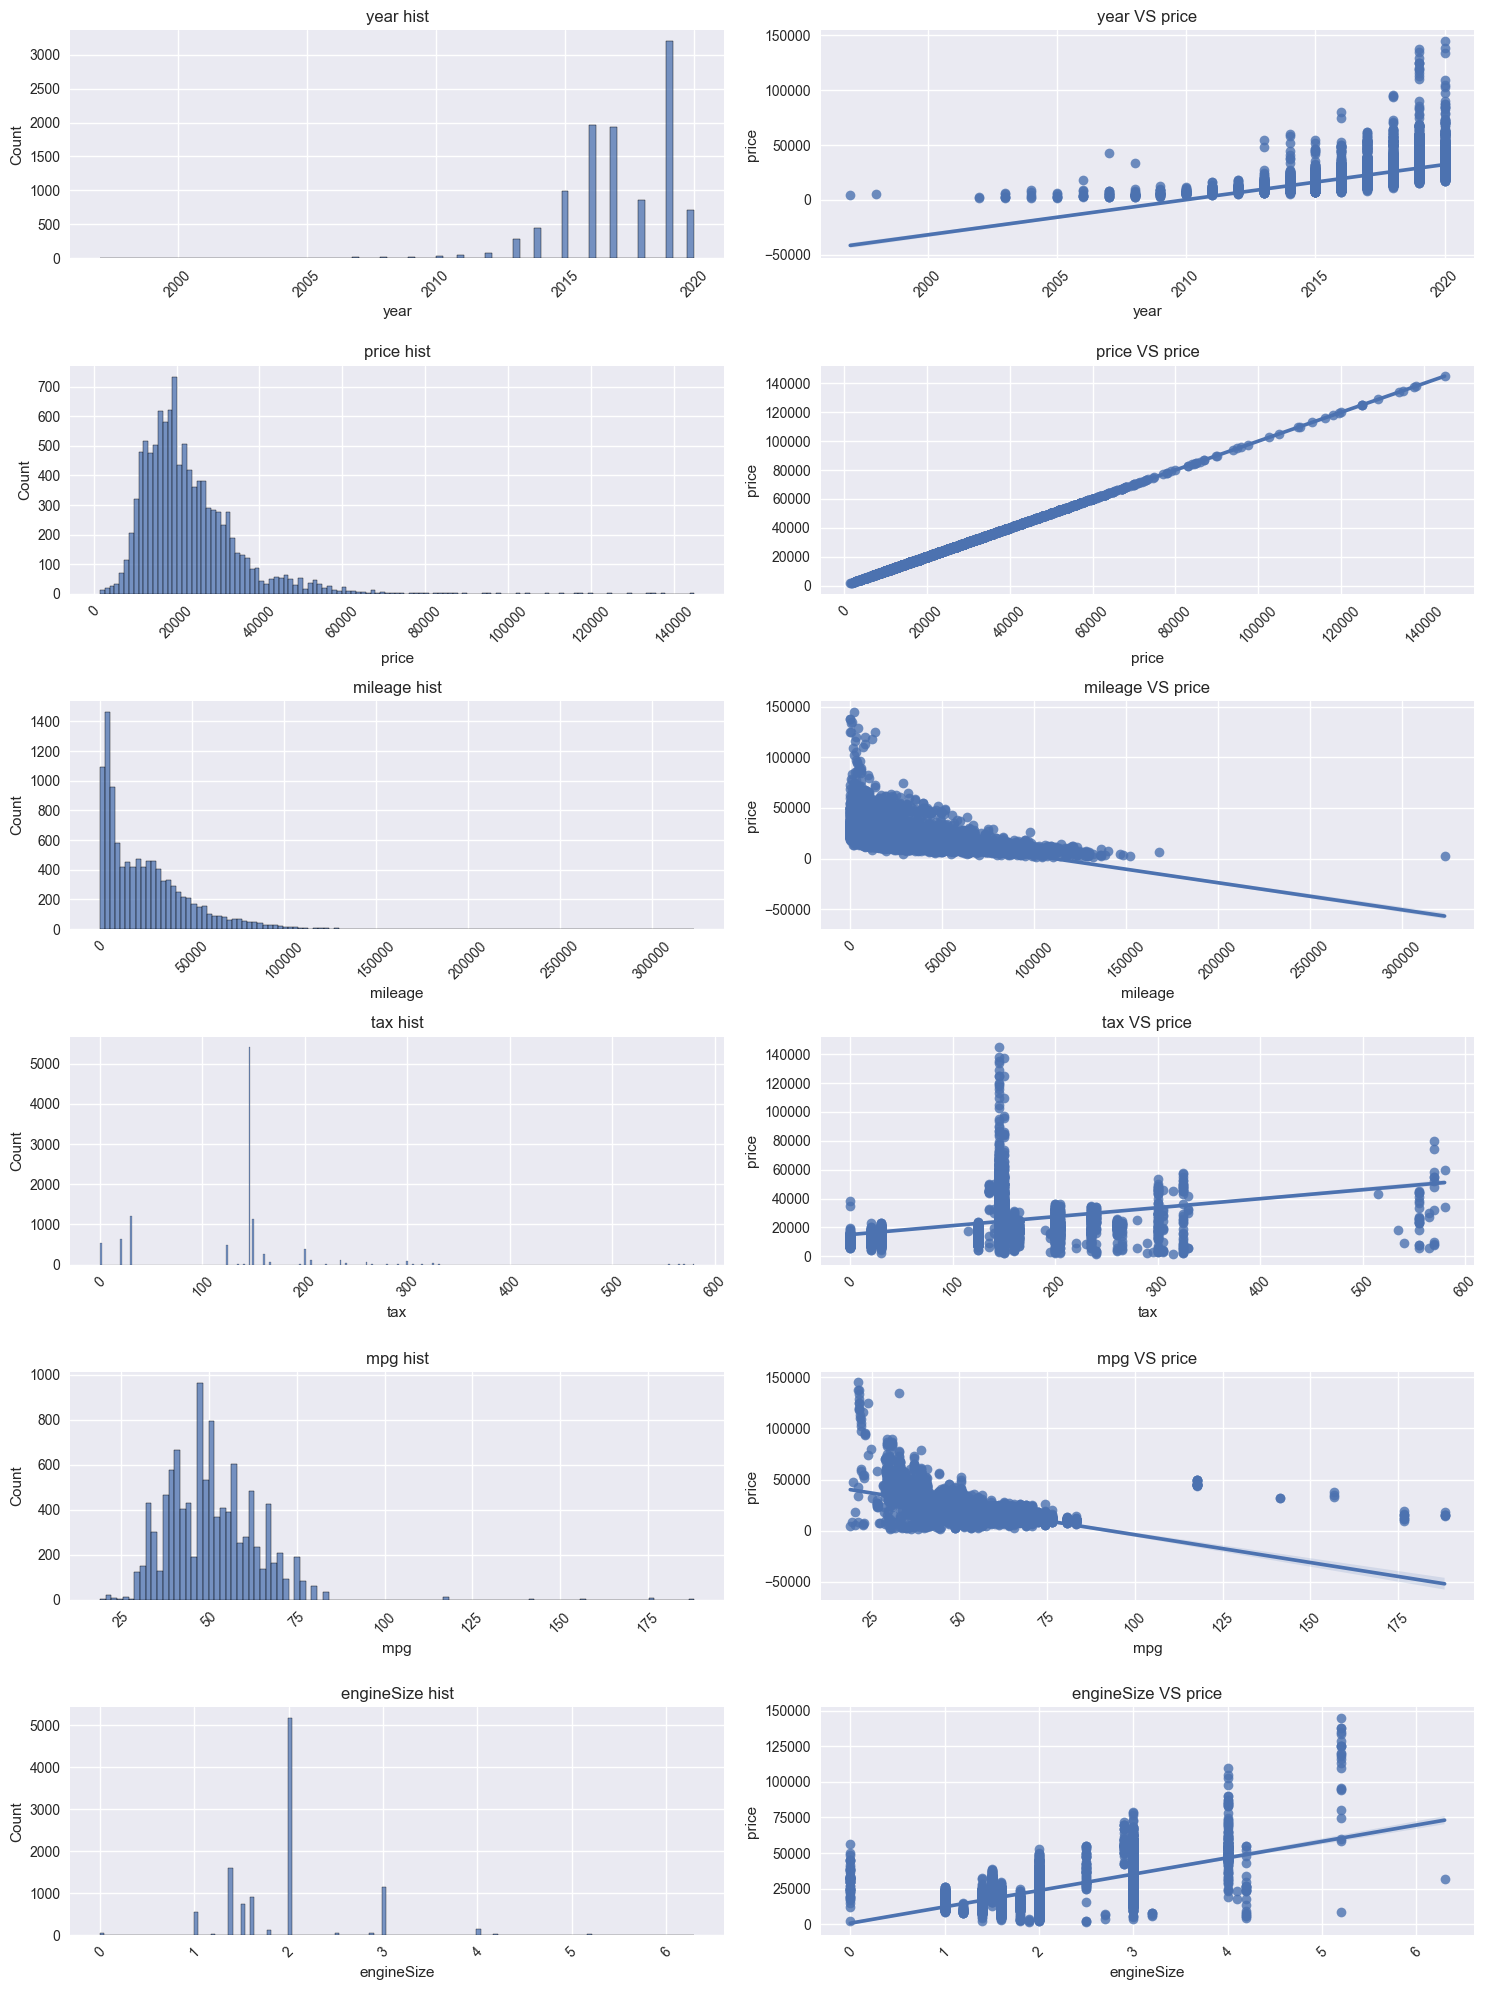

In [9]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='price', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

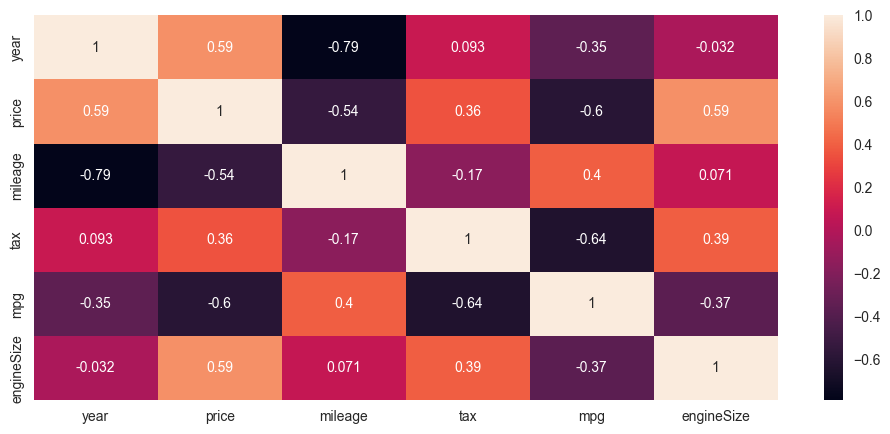

In [10]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data[num_features].corr(), annot=True);

### Подготовка данных

Цель этого этапа — подготовить обучающую выборку для использования в моделировании.

Линейная регрессия, которую мы будем использовать, является моделью, которая требует численного представления данных. То есть на этапе подготовки данных мы должны позаботиться о кодировании текстовых категориальных признаков. 

К тому же, если в ваших данных присутствуют пропуски данных, то необходимо обратать и их, так как пропуски в данных вызовут ошибку при подаче данных в модель.

Произведем One Hot-кодирование категориальных признаков с помощью функции pandas - get_dummies(). 

In [11]:
#Производим кодирование категориальных признаков
dummies_data = pd.get_dummies(temp_data)
dummies_data.head()

,year,price,mileage,tax,mpg,engineSize,model_ A1,model_ A2,model_ A3,model_ A4,...,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,12500,15735,150,55.4,1.4,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,2016,16500,36203,20,64.2,2.0,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,2016,11000,29946,30,55.4,1.4,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,2017,16800,25952,145,67.3,2.0,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
4,2019,17300,1998,145,49.6,1.0,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True


Аналог: знакомый нам OneHotEncoder из библиотеки category_encoders 

In [12]:
# import category_encoders as ce # импорт для работы с кодировщиком

# encoder = ce.OneHotEncoder(cols=['model', 'transmission', 'fuelType']) # указываем столбец для кодирования
# encoding_data = encoder.fit_transform(temp_data[['model', 'transmission', 'fuelType']])
# dummies_data = pd.concat([temp_data.drop(['model', 'transmission', 'fuelType'], axis=1), encoding_data], axis=1)
# dummies_data.head()

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [13]:
#X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('price', axis=1)
y = dummies_data['price']

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [14]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (8534, 37)
Test shape: (2134, 37)


### Моделирование + Оценка модели

Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [15]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

**Модель линейной регрессии:**

Модель линейной регрессии имеет следующий вид:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры линейной регрессии

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 

В качестве функции потерь используем MSE - средний квадрат ошибки.

$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$

**Аналитическое решение: метод наименьших квадратов (OLS):**

$$\omega=(X^TX)^{-1}X^Ty$$

В библиотеке sklearn линейная регрессия с поиском параметров по OLS реализована в классе LinearRegression модуля linear_model. 

Методы:
* fit() - подгонка параметров по OLS (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные с помощью OLS коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [16]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.893
Train MAE: 2550.204
Train MAPE: 13.383


Test R^2: 0.887
Test MAE: 2613.726
Train MAPE: 12.876


**Численное решение: метод стохастического градиентного спуска (SGD):**

$$\omega^{(k+1)} = \omega^{(k)} - \eta\nabla L(\omega^{(k)})$$

В библиотеке sklearn линейная регрессия с поиском параметров по SGD реализована в классе SGDRegressor модуля linear_model. 

Методы:
* fit() - подгонка параметров по SGD (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - полученные с помощью SGD коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [17]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.888
Train MAE: 2566.030
Train MAPE: 13.819


Test R^2: 0.884
Test MAE: 2601.702
Train MAPE: 12.876


Целевое значение метрики MAE в 2 тыс. $ не достигнуто, переходим на следующую итерацию

## Итерация №2

Предположение - качество модели повысится, если:
* Избавиться от выбросов в данных - автомобилей с завышенной (заниженной) ценой, высоким (низким) пробегом и высоким (низким) расходом топливом
* Перевести целевой признак из логнормального распределения в нормальное с помощью логарифмирования

### Исследование данных

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3ех сигм)

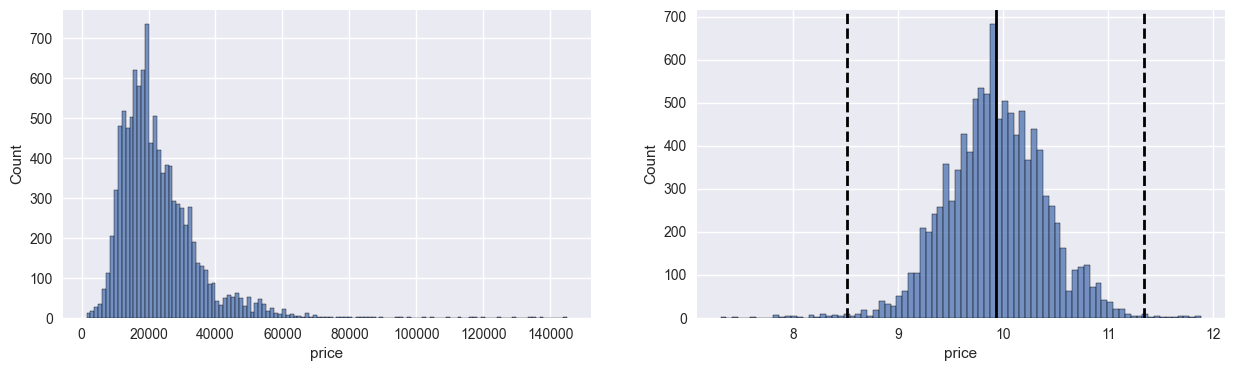

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=temp_data, x='price', ax=axes[0]);
#Логарифмируем
log_price = np.log(temp_data['price'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

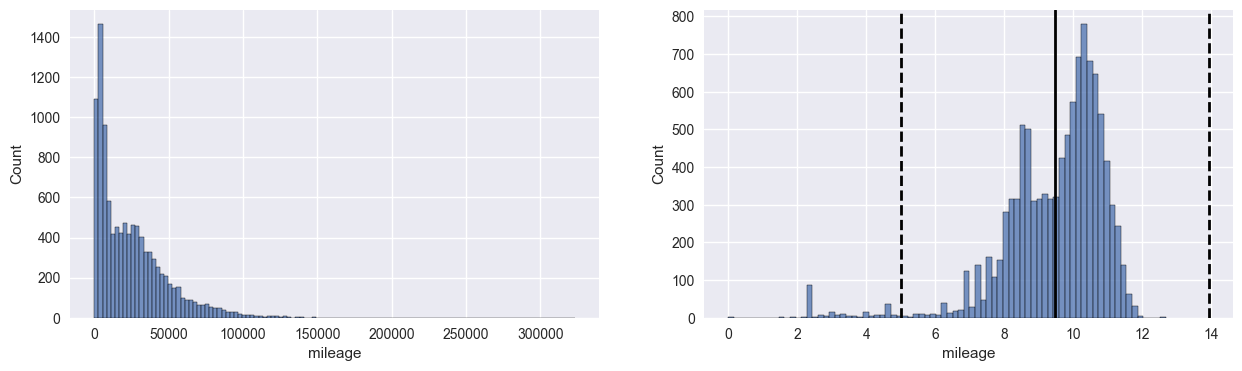

In [19]:
#Строим гистограмму
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=temp_data, x='mileage', ax=axes[0]);
#Логарифмируем
log_price = np.log(temp_data['mileage'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

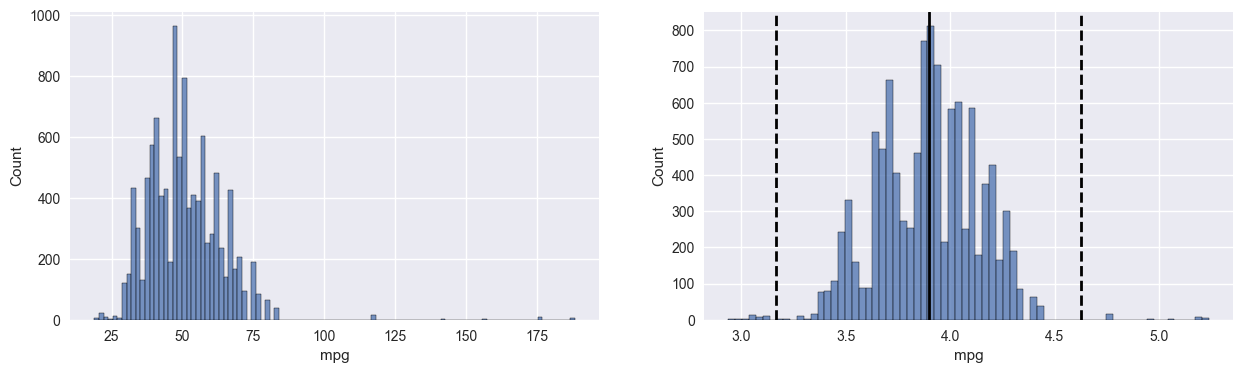

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
#Строим гистограмму
sns.histplot(data=temp_data, x='mpg', ax=axes[0]);
#Логарифмируем
log_price = np.log(temp_data['mpg'])
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

### Подготовка данных

Избавимся от выбросов с помощью метода z-отклонений на логарифмированных признаках. 

Напомним, метод z-отклонений мы изучали в модуле по очистке данных

In [21]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, temp_cleaned = outliers_z_score(temp_data, 'price', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'mileage', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'mpg', log_scale=True)
print('Shape before cleaning outliers: {}'.format(temp_data.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (10668, 9)
Shape after cleaning outliers: (10308, 9)


In [22]:
#Производим кодирование категориальных признаков
dummies_data = pd.get_dummies(temp_cleaned)
dummies_data.head()

,year,price,mileage,tax,mpg,engineSize,model_ A1,model_ A3,model_ A4,model_ A5,...,model_ S5,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Petrol
0,2017,12500,15735,150,55.4,1.4,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,2016,16500,36203,20,64.2,2.0,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,2016,11000,29946,30,55.4,1.4,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,2017,16800,25952,145,67.3,2.0,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
4,2019,17300,1998,145,49.6,1.0,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True


In [23]:
#X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('price', axis=1)
y = dummies_data['price']
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (8246, 35)
Test shape: (2062, 35)


### Моделирование

Построим на предобработанных данных модель линейной регрессии

In [24]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)

#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.927
Train MAE: 1959.201
Train MAPE: 8.712


Test R^2: 0.917
Test MAE: 2060.712
Train MAPE: 9.061


Попробуем добавить в данные полиномиальные признаки и построить модель полиномиальной регрессии. Предварительно нормализуем данные:

In [25]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (8246, 665)
Test shape: (2062, 665)


Попробуем обучить модель линейной регрессии на сгенерированных данных. Спойлер: код выполнится с ошибкой. Причина - слишком высокие коэффициенты модели, из-за чего модель выдает огромные значения цены, которая затем еще и возводится в экспоненту, в результате чего возникает ошибка числа, не помещающегося в тип данных float64. 

In [26]:
# lr_poly = linear_model.LinearRegression()
# lr_poly.fit(X_train_scaled_poly, y_train_log)
# y_train_pred = np.exp(lr_poly.predict(X_train_scaled_poly))
# y_test_pred = np.exp(lr_poly.predict(X_test_scaled_poly))

# print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Решение проблемы огромных значений коэффициентов - использование регуляризации

Идея регуляризации - добавление в модель штрафа за высокие значения коэффициентов, которые являются прямым признаком переобучения. 

**Линейная регрессия с L2-регуляризацией**

L2-регуляризация добавляет к функции ошибки дополнительное слагаемое, которое вносит смещение в обучение модели. Слагаемое - сумма квадратов коэффициентов модели.

$$L(\omega) = MSE + \alpha \sum_{j=1}^{m}{\omega_j^2}$$

$\alpha$ - коэффициент регуляризации, чем он выше, тем большее смещение вносится в модель (тем сильнее штраф за переобучение)

В библиотеке sklearn линейная регрессия с L2-регуляризацией (гребневая регрессия) реализована в классе Ridge модуля linear_model. 

Методы:
* fit() - подгонка параметров по методу координатного спуска - безпроизводный аналов градиентного спуска (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [27]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.946
Train MAE: 1714.759
Train MAPE: 7.798


Test R^2: 0.934
Test MAE: 1826.895
Train MAPE: 8.184


Качество модели можно улучшить, если подробовать подобрать оптимальное значение коэффициента регуляризации $\alpha$ (по умолчанию в реализации sklearn $\alpha = 1$). Нас интересует такое значение коэффициента, при котором наблюдается наилучшее значение метрики на тестовой выборке (наименьшее значение MAE), если таких значений $\alpha$ несколько, то берем то, при котором разница в показателях на тренировочной и тестовой выборке наименьшая.


**Подбор параметра регуляризации $\alpha$**

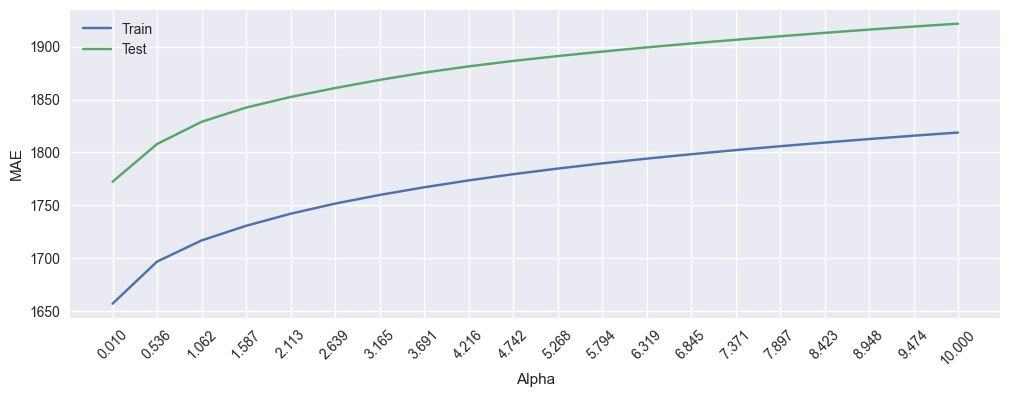

In [28]:
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

Наилучшее значение метрики соотвествует alpha=0.01 (кстати, можно попробовать перебрать значения alpha < 0.01).

Обучим модель линейной регрессии с L2-регуляризацией с коэффициентов регуляризации alpha=0.01

**Финальная модель**

In [29]:
#Создаем объект класса линейная регрессия с L2-регуляризацией
#Выставляем параметр alpha в подобранное выше значение
ridge_lr = linear_model.Ridge(alpha=0.01)
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr.predict(X_test_scaled_poly))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.951
Train MAE: 1656.825
Train MAPE: 7.610


Test R^2: 0.937
Test MAE: 1772.183
Train MAPE: 7.994


Посмотрим на разброс ошибок нашей модели с помощью boxplot-диграммы. Это поможет нам понять, как много автомобилей в каждой из выборок, для которых мы допускаем высокую ошибку в предсказании цены.

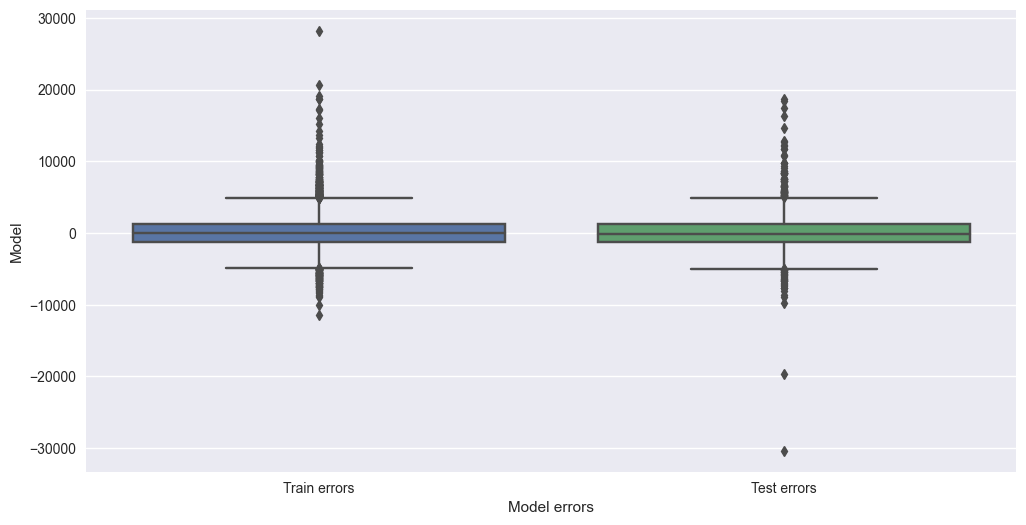

In [30]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Возможные дальнейшие шаги по улучшению:
* feature engineering - попыться сгенерировать новые признаки в данных/присоединить внешние источники, например данные о рейтинге каждой из моделей audi на рынке
* попытаться привести все числовые признаки к нормальному распределению (например, с помощью логарифмирования)
* объединить категориальный признак model в ценовые сегменты автомобилей, чтобы уменьшить количество категорий
* найти наблюдения, для которых наблюдается высокая ошибка между предсказанием и действительностью и понять, что с ними "не так"